# Flower Dataset Clustering

Análisis no supervisado del conjunto de datos de flores utilizando embeddings preentrenados de VGG16, reducción de dimensionalidad con PCA y algoritmos de clustering (K-Means y clustering aglomerativo).

In [1]:
from pathlib import Path

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

DATA_PATH = Path('../../dataset/flowers/FlowerColorImages.h5').resolve()
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True)


2025-10-08 17:58:14.184491: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 17:58:14.224461: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-10-08 17:58:15.550722: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
vgg_model = None

def get_vgg_model():
    global vgg_model
    if vgg_model is None:
        vgg_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        vgg_model.trainable = False
    return vgg_model


def load_dataset(path: Path):
    with h5py.File(path, 'r') as h5_file:
        images = h5_file['images'][:]
        labels = h5_file['labels'][:]
    return images, labels


def extract_vgg16_features(images: np.ndarray, batch_size: int = 32) -> np.ndarray:
    model = get_vgg_model()
    dataset = tf.data.Dataset.from_tensor_slices(images.astype(np.float32))
    dataset = dataset.map(lambda x: tf.image.resize(x, (224, 224)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda x: preprocess_input(x), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    features = []
    for batch in tqdm(dataset, desc='Extrayendo embeddings VGG16'):
        embeddings = model(batch, training=False)
        features.append(embeddings.numpy())

    return np.vstack(features)


def reduce_with_pca(features: np.ndarray, variance_threshold: float = 0.95):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)

    pca = PCA(n_components=variance_threshold, random_state=42)
    embeddings = pca.fit_transform(scaled)
    return embeddings, pca


def evaluate_clustering(embeddings: np.ndarray, cluster_labels: np.ndarray, true_labels: np.ndarray):
    silhouette = silhouette_score(embeddings, cluster_labels)
    davies_bouldin = davies_bouldin_score(embeddings, cluster_labels)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)

    df = pd.DataFrame({'cluster': cluster_labels, 'true': true_labels})
    majority = df.groupby('cluster')['true'].agg(lambda series: series.value_counts().idxmax()).to_dict()
    matched = np.vectorize(majority.get)(cluster_labels)
    purity = np.mean(matched == true_labels)

    return {
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'ARI': ari,
        'NMI': nmi,
        'purity': purity,
        'majority_mapping': majority,
    }


In [3]:
images, labels = load_dataset(DATA_PATH)
print(f'Imágenes cargadas: {images.shape[0]} de tamaño {images.shape[1:]}')
print(f'Etiquetas únicas: {np.unique(labels)}')

Imágenes cargadas: 210 de tamaño (128, 128, 3)
Etiquetas únicas: [0 1 2 3 4 5 6 7 8 9]


In [4]:
features = extract_vgg16_features(images, batch_size=16)
print(f'Embeddings VGG16: {features.shape}')

embeddings, pca = reduce_with_pca(features, variance_threshold=0.95)
print(f'Componentes retenidas: {embeddings.shape[1]}')
print(f'Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}')


       0/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

   16384/58889256 ━━━━━━━━━━━━━━━━━━━━ 3:15 3us/step

   49152/58889256 ━━━━━━━━━━━━━━━━━━━━ 2:55 3us/step

   81920/58889256 ━━━━━━━━━━━━━━━━━━━━ 2:50 3us/step

  147456/58889256 ━━━━━━━━━━━━━━━━━━━━ 2:01 2us/step

  212992/58889256 ━━━━━━━━━━━━━━━━━━━━ 1:38 2us/step

  327680/58889256 ━━━━━━━━━━━━━━━━━━━━ 1:13 1us/step

  458752/58889256 ━━━━━━━━━━━━━━━━━━━━ 58s 1us/step 

  720896/58889256 ━━━━━━━━━━━━━━━━━━━━ 41s 1us/step

 1064960/58889256 ━━━━━━━━━━━━━━━━━━━━ 30s 1us/step

 1630208/58889256 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 2506752/58889256 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 3252224/58889256 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 4104192/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 4857856/58889256 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step 

 5668864/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 6643712/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 7364608/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 8200192/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 9166848/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 9912320/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

10813440/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

11837440/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

12869632/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

13484032/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

14524416/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

15417344/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

16228352/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

17039360/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

17932288/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

18685952/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

19611648/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

20242432/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

21086208/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

22290432/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

22880256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

23822336/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

24805376/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

25575424/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

26648576/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

27680768/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

28270592/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

29278208/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

30326784/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

30908416/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

31965184/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

33038336/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

33587200/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

34627584/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

35659776/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

36233216/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

37314560/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

38281216/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

38985728/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

39919616/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

40992768/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

41787392/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

42737664/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

43573248/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

44392448/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

45572096/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

46383104/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

47144960/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

48275456/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

48898048/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

49864704/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

51077120/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

51650560/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

52649984/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

53968896/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

54427648/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

55435264/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

56573952/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

57286656/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

58228736/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Extrayendo embeddings VGG16:   0%|          | 0/14 [00:00<?, ?it/s]

Extrayendo embeddings VGG16:   7%|▋         | 1/14 [00:01<00:21,  1.63s/it]

Extrayendo embeddings VGG16:  14%|█▍        | 2/14 [00:03<00:19,  1.65s/it]

Extrayendo embeddings VGG16:  21%|██▏       | 3/14 [00:04<00:17,  1.63s/it]

Extrayendo embeddings VGG16:  29%|██▊       | 4/14 [00:06<00:15,  1.58s/it]

Extrayendo embeddings VGG16:  36%|███▌      | 5/14 [00:07<00:13,  1.55s/it]

Extrayendo embeddings VGG16:  43%|████▎     | 6/14 [00:09<00:12,  1.53s/it]

Extrayendo embeddings VGG16:  50%|█████     | 7/14 [00:10<00:10,  1.54s/it]

Extrayendo embeddings VGG16:  57%|█████▋    | 8/14 [00:12<00:09,  1.52s/it]

Extrayendo embeddings VGG16:  64%|██████▍   | 9/14 [00:13<00:07,  1.51s/it]

Extrayendo embeddings VGG16:  71%|███████▏  | 10/14 [00:15<00:06,  1.50s/it]

Extrayendo embeddings VGG16:  79%|███████▊  | 11/14 [00:16<00:04,  1.50s/it]

Extrayendo embeddings VGG16:  86%|████████▌ | 12/14 [00:18<00:03,  1.51s/it]

Extrayendo embeddings VGG16:  93%|█████████▎| 13/14 [00:19<00:01,  1.51s/it]

Extrayendo embeddings VGG16: 100%|██████████| 14/14 [00:20<00:00,  1.12s/it]

2025-10-08 17:58:40.791683: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Extrayendo embeddings VGG16: 100%|██████████| 14/14 [00:20<00:00,  1.44s/it]

Embeddings VGG16: (210, 512)
Componentes retenidas: 130
Varianza explicada: 95.09%


In [5]:
k = len(np.unique(labels))
print(f'Número de clusters: {k}')

kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
agglomerative = AgglomerativeClustering(n_clusters=k, linkage='ward')

kmeans_labels = kmeans.fit_predict(embeddings)
agglomerative_labels = agglomerative.fit_predict(embeddings)

kmeans_metrics = evaluate_clustering(embeddings, kmeans_labels, labels)
agglomerative_metrics = evaluate_clustering(embeddings, agglomerative_labels, labels)

metrics_df = pd.DataFrame({
    'KMeans': {k: v for k, v in kmeans_metrics.items() if k != 'majority_mapping'},
    'Agglomerative': {k: v for k, v in agglomerative_metrics.items() if k != 'majority_mapping'},
})

metrics_df.round(3)

Número de clusters: 10


,KMeans,Agglomerative
silhouette,0.090,-0.005
davies_bouldin,2.331,2.409
ARI,0.086,0.187
NMI,0.346,0.421
purity,0.348,0.390


In [6]:
print('Mapeo mayoritario KMeans:')
for cluster, label in sorted(kmeans_metrics['majority_mapping'].items()):
    print(f'  Cluster {cluster} -> clase {label}')

print('\nMapeo mayoritario Aglomerativo:')
for cluster, label in sorted(agglomerative_metrics['majority_mapping'].items()):
    print(f'  Cluster {cluster} -> clase {label}')

kmeans_ct = pd.crosstab(labels, kmeans_labels, rownames=['true'], colnames=['cluster'])
agglomerative_ct = pd.crosstab(labels, agglomerative_labels, rownames=['true'], colnames=['cluster'])

kmeans_ct, agglomerative_ct

Mapeo mayoritario KMeans:
  Cluster 0 -> clase 9
  Cluster 1 -> clase 6
  Cluster 2 -> clase 4
  Cluster 3 -> clase 6
  Cluster 4 -> clase 1
  Cluster 5 -> clase 3
  Cluster 6 -> clase 9
  Cluster 7 -> clase 2
  Cluster 8 -> clase 2
  Cluster 9 -> clase 3

Mapeo mayoritario Aglomerativo:
  Cluster 0 -> clase 1
  Cluster 1 -> clase 5
  Cluster 2 -> clase 9
  Cluster 3 -> clase 4
  Cluster 4 -> clase 3
  Cluster 5 -> clase 5
  Cluster 6 -> clase 2
  Cluster 7 -> clase 5
  Cluster 8 -> clase 6
  Cluster 9 -> clase 4


(cluster   0   1   2  3   4  5  6  7   8  9
 true                                      
 0         2   0  12  0   7  0  0  0   0  0
 1         0   0   6  0  14  0  0  0   0  0
 2         0   0   7  0   0  0  0  1  11  0
 3         3   0   9  0   8  1  0  0   0  1
 4         0   0  18  0   0  0  0  0   3  0
 5         7   0  15  0   2  0  1  0   0  0
 6         0  10   8  5   0  0  0  0   0  0
 7         0   0  15  0   0  0  0  0   0  0
 8         0   0  12  0  14  0  0  0   0  0
 9        10   0   3  0   3  0  2  0   0  0,
 cluster   0  1  2   3  4   5  6  7   8  9
 true                                     
 0         5  0  2   2  0  12  0  0   0  0
 1        16  0  0   0  0   4  0  0   0  0
 2         0  0  0  17  0   1  1  0   0  0
 3         0  0  6   0  3  13  0  0   0  0
 4         0  0  0  19  0   0  0  0   0  2
 5         1  1  5   0  0  17  0  1   0  0
 6         0  1  0   2  0   7  0  0  13  0
 7         0  0  0  14  0   1  0  0   0  0
 8         9  0  1   7  0   9  0  0   0  

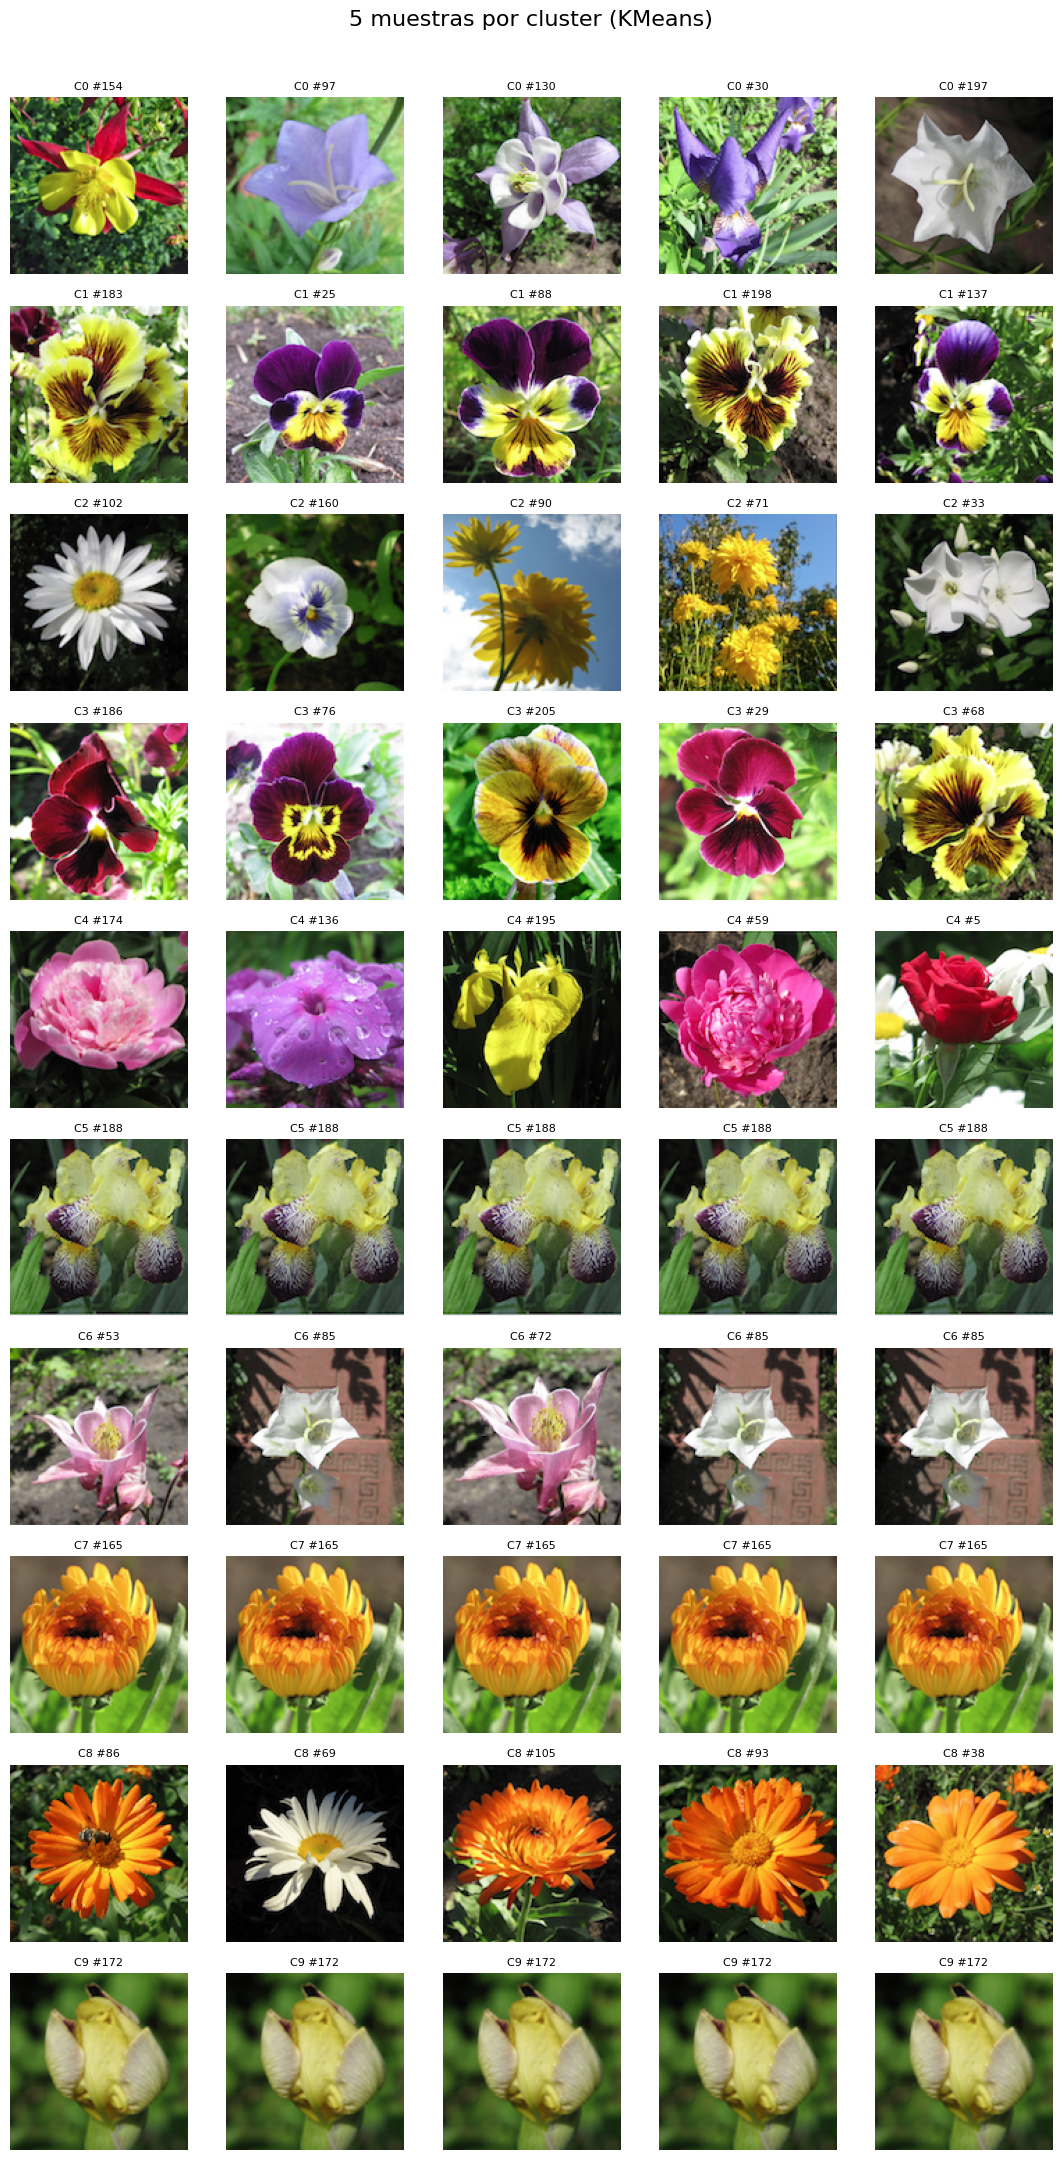

In [7]:
samples_per_cluster = 5
n_clusters = len(np.unique(kmeans_labels))
rng = np.random.default_rng(42)

fig, axes = plt.subplots(n_clusters, samples_per_cluster, figsize=(samples_per_cluster * 2.2, n_clusters * 2.2))

for cluster in range(n_clusters):
    cluster_indices = np.where(kmeans_labels == cluster)[0]
    if len(cluster_indices) == 0:
        for j in range(samples_per_cluster):
            axes[cluster, j].axis('off')
        continue

    if len(cluster_indices) >= samples_per_cluster:
        chosen = rng.choice(cluster_indices, samples_per_cluster, replace=False)
    else:
        chosen = rng.choice(cluster_indices, samples_per_cluster, replace=True)

    for col, idx in enumerate(chosen):
        axes[cluster, col].imshow(images[idx].astype(np.uint8))
        axes[cluster, col].set_title(f'C{cluster} #{idx}', fontsize=8)
        axes[cluster, col].axis('off')

for ax in axes.ravel():
    if not hasattr(ax, 'images') or len(ax.images) == 0:
        ax.axis('off')

fig.suptitle('5 muestras por cluster (KMeans)', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])

Figura guardada en: /home/ruben/Documentos/GitHub/EC/src/lab5/outputs/flowers_pca_projection.png


/tmp/ipykernel_28420/1831602274.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


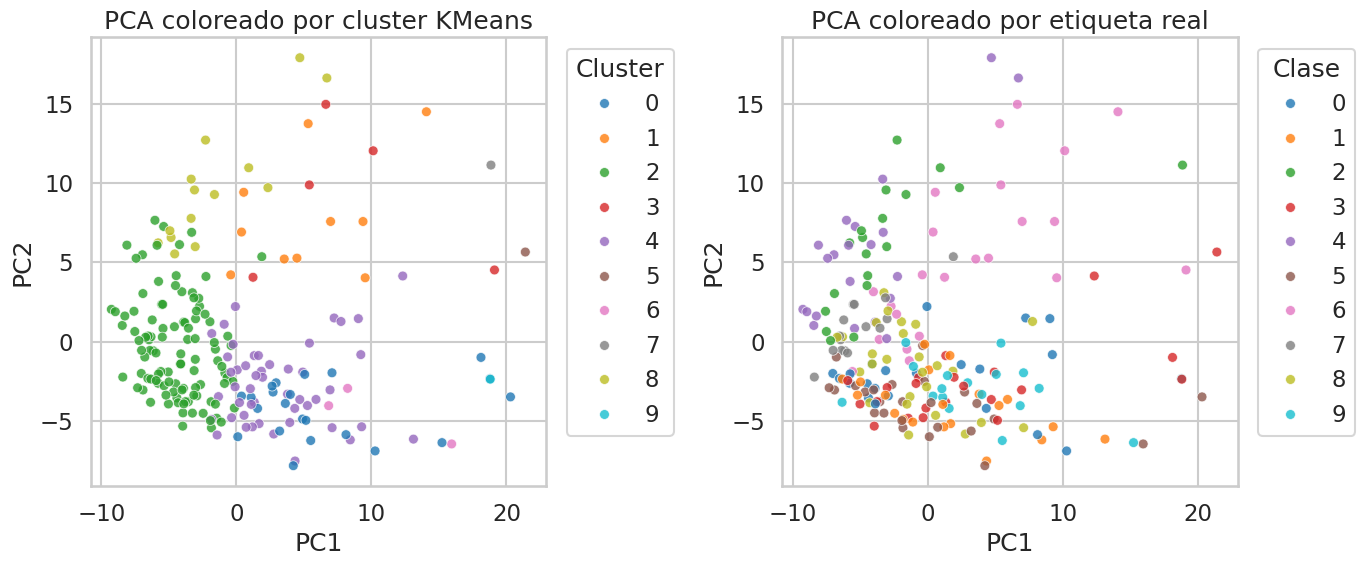

In [8]:
sns.set(style='whitegrid', context='talk')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_df = pd.DataFrame({
    'PC1': embeddings[:, 0],
    'PC2': embeddings[:, 1],
    'kmeans_cluster': kmeans_labels,
    'true_label': labels,
})

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='kmeans_cluster', palette='tab10', s=50, alpha=0.8, ax=axes[0])
axes[0].set_title('PCA coloreado por cluster KMeans')
axes[0].legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='true_label', palette='tab10', s=50, alpha=0.8, ax=axes[1])
axes[1].set_title('PCA coloreado por etiqueta real')
axes[1].legend(title='Clase', bbox_to_anchor=(1.02, 1), loc='upper left')

fig.tight_layout()
plot_path = OUTPUT_DIR / 'flowers_pca_projection.png'
fig.savefig(plot_path, dpi=200)
print(f'Figura guardada en: {plot_path.resolve()}')
fig.show()